In [1]:
import sys, os
import numpy as np

#matplotlib.use("Qt4Agg")
from matplotlib import pyplot as plt
from matplotlib import rc, font_manager

from scipy.signal import resample
from obspy.core import read, Trace, UTCDateTime

from plot_deramp import plot_data, plot_model

%matplotlib inline

In [4]:
# define some input parameters


"""
rotfile    :  input file containing rotation rate data (in miniseed format)
rampfile   :  input file containing ramp data (in miniseed format)
n_samp     :  number of samples used for the correction
n_avg      :  window length for moving average
"""


##########################################
rotfname = '../test_data/FOG.mseed'
rampfname = '../test_data/RAMP.mseed'

# we do not want to process the whole data, so we cut out n_samp samples:
n_samp = 7500

# define a window length for the moving average window. You can play around with this parameter:
# the smaller the window length, the more accurate is the model.
n_avg = 1

In [5]:
# read input files and cut out a number of samples
st_rot = read(rotfname)
st_ramp = read(rampfname)

t1 = st_rot[0].stats.starttime
t2 = t1 + n_samp/st_rot[0].stats.sampling_rate

st_rot.trim(t1, t2)
st_ramp.trim(t1, t2)

print st_rot
print st_ramp

fog = st_rot[0].data
ramp = st_ramp[0].data

1 Trace(s) in Stream:
XS.BS1..HJ3 | 2017-10-14T01:59:59.999800Z - 2017-10-14T02:00:37.499800Z | 200.0 Hz, 7501 samples
1 Trace(s) in Stream:
XS.BS1..YR3 | 2017-10-14T01:59:59.999800Z - 2017-10-14T02:00:37.499800Z | 200.0 Hz, 7501 samples


In [6]:
# lets get the mean value from our fog data
mean = np.mean(fog)

In [7]:
# in this cell we will calculate the (fog as a function of ramp)-model

# lets put together a 2d array with fog and ramp data
a = np.array([fog, ramp])

# sort this array according to ramp (a[1])
idx = np.argsort(a[1])
b = a[:,idx]

# Now calculate the moving average of the fog data across this sorted array.
# This gives us our (fog as a funktion of ramp)-model. The model is more accurate the smaller is n_avg
mavg = np.convolve(b[0], np.ones((n_avg,))/n_avg, mode='valid')

# For each ramp value we want to have a fog value. This means, that we need to resample our model to the length
# of the maximum ramp value
model = resample(mavg, max(ramp))

In [8]:
# Now we can correct for the difference between the mean and the model
diff = model - mean
result = np.empty(len(fog))
for j in range(len(fog)): 
    result[j] = fog[j] - diff[int(ramp[j])-1]



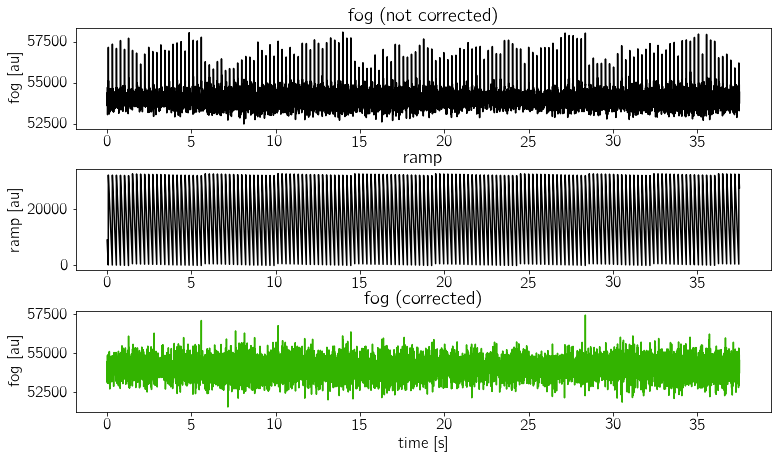

In [9]:
plot_data(fog, ramp, result, st_rot[0].stats.sampling_rate)

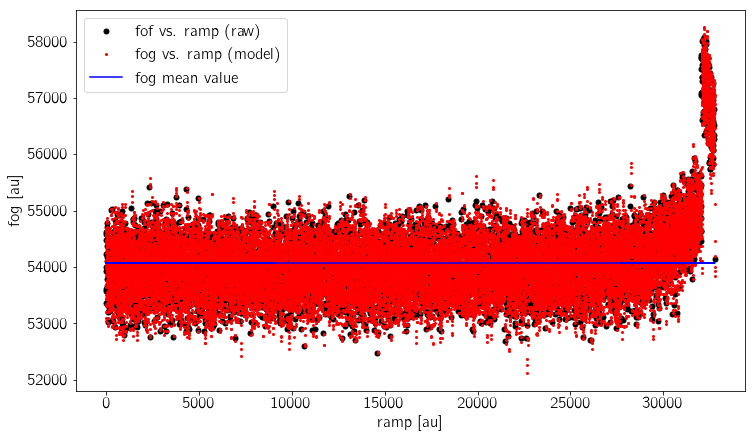

In [10]:
plot_model(fog, ramp, model, mean)